# PointNet Implementation
## for Semantic Segmentation

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
import scipy.constants as spc

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

plotpath = '/home/russbate/MLPionCollaboration/LCStudies/segmentation/Plots/October/'

## Declare GPUs and Import TensorFlow

In [30]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

2021-10-28 14:49:16.568922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:88:00.0, compute capability: 7.5


['/device:GPU:0']

## Load Models for PointNet

## Load Data
### X = [Energy, Eta, Phi, rPerp]
### Y = [EM Energy, non EM Energy]

In [103]:
t0 = t.time()
Xraw = np.load('/data/atlas/rbate/Rho_X_4_files.npy', mmap_mode='r')[:,:,:]
Yraw = np.load('/data/atlas/rbate/Rho_Y_4_files.npy', mmap_mode='r')[:,:,:]
print(Xraw.shape)
print(Yraw.shape)

X = np.lib.format.open_memmap('/data/atlas/rbate/XR_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], Xraw.shape[2]))

Y = np.lib.format.open_memmap('/data/atlas/rbate/YR_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0], Yraw.shape[1], Yraw.shape[2]))
np.copyto(dst=Y, src=Yraw[:,:,:], casting='same_kind', where=True)
t1 = t.time()

Energy_EM = np.ndarray.copy(Yraw[:,:,0])
Energy_nonEM = np.ndarray.copy(Yraw[:,:,1])
nz_mask = (Energy_EM + Energy_nonEM) != 0

# Make sure that non-zero elements are copied as zeros due to mis-match
np.copyto(dst=X[nz_mask,:], src=Xraw[nz_mask,:], casting='same_kind', where=True)
X[np.invert(nz_mask),:] = 0

print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

(2550, 1078, 4)
(2550, 1078, 2)
Time to load memory mapped data: 0.31387925148010254 (s)


## Create Categorization Labels
Still don't know what to do with the mismatch between truth and reported cells

In [104]:
EM = np.full(nz_mask.shape, np.nan)
nonEM = np.full(nz_mask.shape, np.nan)
target_ratio = np.full((nz_mask.shape), np.nan)

EM[nz_mask] = np.ndarray.copy(Yraw[nz_mask,0])
nonEM[nz_mask] = np.ndarray.copy(Yraw[nz_mask,1])

target_labels = np.full((nz_mask.shape[0],nz_mask.shape[1],3), 0)
target_ratio[nz_mask] = EM[nz_mask] / (EM[nz_mask] + nonEM[nz_mask])

em_mask = target_ratio > .8
nonem_mask = target_ratio < .2
mix_mask = np.invert(np.logical_or(em_mask, nonem_mask))

target_labels[em_mask,0] = 1
target_labels[mix_mask,1] = 1
target_labels[nonem_mask,2] = 1

print('Number EM: '+str(np.count_nonzero(em_mask)))
print('Number NON-EM: '+str(np.count_nonzero(nonem_mask)))
print('Number MIX: '+str(np.count_nonzero(mix_mask)))

# change the pointer for Y to the target labels
Y = target_labels

Number EM: 389638
Number NON-EM: 18871
Number MIX: 2340391


#### Troubleshooting step:
 - [x] Make sure that target ratio and inputs have no nan values
 - [x] make sure that the X array is using the nz_mask so there are no mis-matches
   - This seems to be the problem, the mis-matches between values were yielding nans in the training!

In [105]:
print(np.any(target_labels == np.nan))
print(np.any(X == np.nan))

False
False


## Point Normalization
 - [x] Convert to x,y,z
 - [x] Investigate Inputs (Rho_Pre-processing.ipynb)
 - [ ] Speed up the normalization process!

In [106]:
print(cell_mask.shape)
print(X[nz_mask, :3].shape)

t0 = t.time()
X[nz_mask, 1:4] = dsu.to_xyz(X[nz_mask, 1:4])

t1 = t.time()

## ENERGY ##
log_E_mask = X[:,:,0] > 0
X[log_E_mask,0] = np.log(X[log_E_mask,0])

## X ##
X[:,:,1] = X[:,:,1]/3000

## Y ##
X[:,:,2] = X[:,:,2]/1000

## Z ##
X[:,:,3] = X[:,:,3]/1000
t2 = t.time()

print('Time to convert to xyz: '+str(t1-t0)+' (s)')
print('Time to normalize: '+str(t2-t1)+' (s)')
print('Total time: '+str(t2-t0)+' (s)')
print('Target shape: '+str(Y.shape))
print('Input shape: '+str(X.shape))

(2550, 1078)
(527667, 3)
Time to convert to xyz: 56.595319747924805 (s)
Time to normalize: 0.15347528457641602 (s)
Total time: 56.74879503250122 (s)
Target shape: (2550, 1078, 3)
Input shape: (2550, 1078, 4)


### More Data Pre-Processing
Working on solution for points of varying input, this should be taken care of with the max pooling layer

In [107]:
NUM_POINTS = X.shape[1]
NUM_CLASSES = 3

## Build Model

In [119]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.config.run_functions_eagerly(True)

In [120]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [121]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)
        
    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2,2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [122]:
def tnet(inputs, num_features):
    
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
    
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2,1))([inputs, feat_T])

In [123]:
inputs = keras.Input(shape=(NUM_POINTS, 4))

x = tnet(inputs, 4)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_POINTS*NUM_CLASSES, activation="softmax")(x)
resh_out = layers.Reshape((NUM_POINTS, NUM_CLASSES))(outputs)

point_net_1 = keras.Model(inputs=inputs, outputs=resh_out, name="point_net_1")
point_net_1.summary()

Model: "point_net_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1078, 4)]    0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 1078, 32)     160         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 1078, 32)     128         conv1d_55[0][0]                  
__________________________________________________________________________________________________
activation_85 (Activation)      (None, 1078, 32)     0           batch_normalization_85[0][0]     
________________________________________________________________________________________

#### Compile Model

In [124]:
point_loss = keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy",
)

point_optimizer = keras.optimizers.Adam(learning_rate=0.005)

point_net_1.compile(loss=point_loss, optimizer=point_optimizer)

## Set up Datasets and Shuffle

In [125]:
train_num, val_num, test_num = dsu.tvt_num(X, tvt=(70,15,15))
print('Number of training samples: '+str(train_num))
print('Number of validation samples: '+str(val_num))
print('Number of test samples: '+str(test_num))

Number of training samples: 1785
Number of validation samples: 382
Number of test samples: 383


### Using TF DataSets

In [126]:
# dataset = tf.data.Dataset.from_tensor_slices((X,Y))

# example_dataset = dataset.as_numpy_iterator()
# element = example_dataset.next()
# Xa, Ya = element

# dat_tr = dataset.skip(val_num+test_num)
# dat_test = dataset.take(test_num+val_num)
# dat_val = dat_test.skip(test_num)
# dat_test = dataset.take(test_num)

# print(dat_tr.cardinality())
# print(dat_test.cardinality())
# print(dat_val.cardinality())

In [127]:
# Nbatches = int(np.ceil(1785/382))
# print(Nbatches)
# batch_size=int(np.floor(1785/Nbatches))
# print(batch_size)

# dat_tr = dat_tr.batch(Nbatches, drop_remainder=True)
# dat_val = dat_val.batch(Nbatches, drop_remainder=True)
# dat_test = dat_test.batch(Nbatches, drop_remainder=True)

### Using numpy arrays

In [128]:
X_train = np.ndarray.copy(X[:train_num,:,:])
Y_train = np.ndarray.copy(Y[:train_num,:,:])

X_val = np.ndarray.copy(X[train_num:train_num+val_num,:,:])
Y_val = np.ndarray.copy(Y[train_num:train_num+val_num,:,:])

X_test = np.ndarray.copy(X[train_num+val_num:,:,:])
Y_test = np.ndarray.copy(Y[train_num+val_num:,:,:])

In [129]:
print(Y_train.shape)
print(X_train.shape)

(1785, 1078, 3)
(1785, 1078, 4)


### Train

In [130]:
history_1 = point_net_1.fit(x=X_train, y=Y_train,
                           epochs=100,
                           batch_size=100,
                           validation_data=(X_val, Y_val),
                           verbose=1)

Epoch 1/100


2021-10-29 15:07:18.575683: I tensorflow/stream_executor/cuda/cuda_driver.cc:732] failed to allocate 4.00G (4294967296 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-10-29 15:07:18.581667: I tensorflow/stream_executor/cuda/cuda_driver.cc:732] failed to allocate 3.60G (3865470464 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-10-29 15:07:18.583286: I tensorflow/stream_executor/cuda/cuda_driver.cc:732] failed to allocate 3.24G (3478923264 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-10-29 15:07:18.584751: I tensorflow/stream_executor/cuda/cuda_driver.cc:732] failed to allocate 2.92G (3131030784 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-10-29 15:07:18.586752: I tensorflow/stream_executor/cuda/cuda_driver.cc:732] failed to allocate 2.62G (2817927680 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-10-29 15:07:18.588587: I tensorflow/stream_executor/cuda/cuda_driver.cc:732] failed to allocate 2.36

18/18 [==============================] - 6s 267ms/step - loss: 7.1958 - val_loss: 6.4098
Epoch 2/100
18/18 [==============================] - 5s 266ms/step - loss: 6.1861 - val_loss: 5.6272
Epoch 3/100
18/18 [==============================] - 4s 248ms/step - loss: 5.5103 - val_loss: 5.0967
Epoch 4/100
18/18 [==============================] - 5s 283ms/step - loss: 5.0528 - val_loss: 4.7349
Epoch 5/100
18/18 [==============================] - 4s 250ms/step - loss: 4.7370 - val_loss: 4.4802
Epoch 6/100
18/18 [==============================] - 5s 257ms/step - loss: 4.5120 - val_loss: 4.2953
Epoch 7/100
18/18 [==============================] - 5s 262ms/step - loss: 4.3469 - val_loss: 4.1571
Epoch 8/100
18/18 [==============================] - 5s 256ms/step - loss: 4.2224 - val_loss: 4.0512
Epoch 9/100
18/18 [==============================] - 4s 250ms/step - loss: 4.1261 - val_loss: 3.9685
Epoch 10/100
18/18 [==============================] - 4s 239ms/step - loss: 4.0504 - val_loss: 3.9025
E

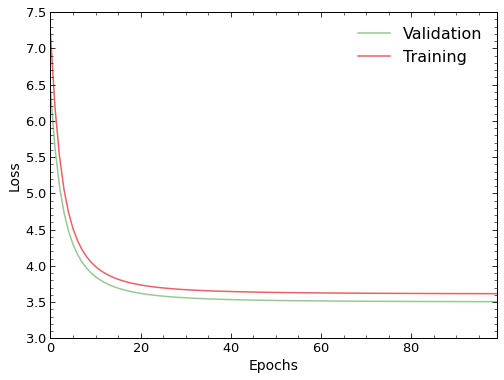

In [131]:
fig = plt.figure(figsize=(8,6))
plt.plot(history_1.history['val_loss'], label="Validation")
plt.plot(history_1.history['loss'], label="Training")
plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,len(history_1.history['loss'])-1)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1, prop={"family":'DejaVu Sans', 'size':'16'})
# plt.text(1000, 1.5, 'LR=1e-3', fontsize=13)
# plt.text(1000, 1, 'Batch: 3000', fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/STSC_lossCurves_3000batch_LR1e-3_2021-07-26.png', format='png')
plt.show()

### Producing plots of predictions versus truth

In [132]:
# print(dat_test.cardinality())

# dat_test.get_single_element()
# # print(tf.rank(dat_test))
# print('Batch size: '+str(int(batch_size)))
# keras.backend.int_shape(dat_test)

In [134]:
preds_1 = point_net_1.predict(X_test)

In [138]:
print(np.shape(preds_1))
print(preds_1[0,:150,:])

(383, 1078, 3)
[[6.19573693e-04 3.54599979e-05 6.24664608e-06]
 [6.08299219e-04 5.98753395e-05 5.38312042e-06]
 [6.02630083e-04 5.75550475e-05 5.50933737e-06]
 [5.56852727e-04 5.99361847e-05 6.26176552e-06]
 [5.44310024e-04 6.06031026e-05 6.52402287e-06]
 [5.45506773e-04 6.80253652e-05 6.39442078e-06]
 [5.38717548e-04 5.92388351e-05 6.65066182e-06]
 [5.26384101e-04 6.15726603e-05 6.94262781e-06]
 [5.30141755e-04 6.49437716e-05 6.81588108e-06]
 [5.19144465e-04 7.85828161e-05 6.99270595e-06]
 [5.51715319e-04 7.61550837e-05 6.28900489e-06]
 [5.27646625e-04 6.58566569e-05 6.80129097e-06]
 [5.51671430e-04 7.57705347e-05 6.28133512e-06]
 [5.30795078e-04 8.38611159e-05 6.74603325e-06]
 [5.32164238e-04 7.34763598e-05 6.69567726e-06]
 [4.97064204e-04 8.08675904e-05 7.61479623e-06]
 [5.84972848e-04 9.95536975e-05 5.73116813e-06]
 [5.26546384e-04 1.74861605e-04 8.60070395e-06]
 [4.94066044e-04 9.18790320e-05 7.69766757e-06]
 [5.30276506e-04 1.13066257e-04 7.14850876e-06]
 [5.11041842e-04 1.034454